Step1: **Colour space transformation from RGB to Y-Cb-Cr**

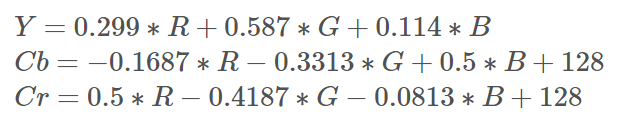

In [53]:
from collections import Counter

import numpy as np


def zigzag(matrix: np.ndarray) -> np.ndarray:
    """
    computes the zigzag of a quantized block
    :param numpy.ndarray matrix: quantized matrix
    :returns: zigzag vectors in an array
    """
    # initializing the variables
    h = 0
    v = 0
    v_min = 0
    h_min = 0
    v_max = matrix.shape[0]
    h_max = matrix.shape[1]
    i = 0
    output = np.zeros((v_max * h_max))

    while (v < v_max) and (h < h_max):
        if ((h + v) % 2) == 0:  # going up
            if v == v_min:
                output[i] = matrix[v, h]  # first line
                if h == h_max:
                    v = v + 1
                else:
                    h = h + 1
                i = i + 1
            elif (h == h_max - 1) and (v < v_max):  # last column
                output[i] = matrix[v, h]
                v = v + 1
                i = i + 1
            elif (v > v_min) and (h < h_max - 1):  # all other cases
                output[i] = matrix[v, h]
                v = v - 1
                h = h + 1
                i = i + 1
        else:  # going down
            if (v == v_max - 1) and (h <= h_max - 1):  # last line
                output[i] = matrix[v, h]
                h = h + 1
                i = i + 1
            elif h == h_min:  # first column
                output[i] = matrix[v, h]
                if v == v_max - 1:
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
            elif (v < v_max - 1) and (h > h_min):  # all other cases
                output[i] = matrix[v, h]
                v = v + 1
                h = h - 1
                i = i + 1
        if (v == v_max - 1) and (h == h_max - 1):  # bottom right element
            output[i] = matrix[v, h]
            break
    return output


def trim(array: np.ndarray) -> np.ndarray:
    """
    in case the trim_zeros function returns an empty array, add a zero to the array to use as the DC component
    :param numpy.ndarray array: array to be trimmed
    :return numpy.ndarray:
    """
    trimmed = np.trim_zeros(array, 'b')
    if len(trimmed) == 0:
        trimmed = np.zeros(1)
    return trimmed


def run_length_encoding(array: np.ndarray) -> list:
    """
    finds the intermediary stream representing the zigzags
    format for DC components is <size><amplitude>
    format for AC components is <run_length, size> <Amplitude of non-zero>
    :param numpy.ndarray array: zigzag vectors in array
    :returns: run length encoded values as an array of tuples
    """
    encoded = list()
    run_length = 0
    eob = ("EOB",)

    for i in range(len(array)):
        for j in range(len(array[i])):
            trimmed = trim(array[i])
            if j == len(trimmed):
                encoded.append(eob)  # EOB
                break
            if i == 0 and j == 0:  # for the first DC component
                encoded.append((int(trimmed[j]).bit_length(), trimmed[j]))
            elif j == 0:  # to compute the difference between DC components
                diff = int(array[i][j] - array[i - 1][j])
                if diff != 0:
                    encoded.append((diff.bit_length(), diff))
                else:
                    encoded.append((1, diff))
                run_length = 0
            elif trimmed[j] == 0:  # increment run_length by one in case of a zero
                run_length += 1
            else:  # intermediary steam representation of the AC components
                encoded.append((run_length, int(trimmed[j]).bit_length(), trimmed[j]))
                run_length = 0
            # send EOB
        if not (encoded[len(encoded) - 1] == eob):
            encoded.append(eob)
    return encoded


def get_freq_dict(array: list) -> dict:
    """
    returns a dict where the keys are the values of the array, and the values are their frequencies
    :param numpy.ndarray array: intermediary stream as array
    :return: frequency table
    """
    #
    data = Counter(array)
    result = {k: d / len(array) for k, d in data.items()}
    return result


def find_huffman(p: dict) -> dict:
    """
    returns a Huffman code for an ensemble with distribution p
    :param dict p: frequency table
    :returns: huffman code for each symbol
    """
    # Base case of only two symbols, assign 0 or 1 arbitrarily; frequency does not matter
    if len(p) == 2:
        return dict(zip(p.keys(), ['0', '1']))

    # Create a new distribution by merging lowest probable pair
    p_prime = p.copy()
    a1, a2 = lowest_prob_pair(p)
    p1, p2 = p_prime.pop(a1), p_prime.pop(a2)
    p_prime[a1 + a2] = p1 + p2

    # Recurse and construct code on new distribution
    c = find_huffman(p_prime)
    ca1a2 = c.pop(a1 + a2)
    c[a1], c[a2] = ca1a2 + '0', ca1a2 + '1'

    return c


def lowest_prob_pair(p):
    # Return pair of symbols from distribution p with lowest probabilities
    sorted_p = sorted(p.items(), key=lambda x: x[1])
    return sorted_p[0][0], sorted_p[1][0]

In [56]:
# python 3.9.5
from math import ceil
import cv2
import numpy as np

# Step 1: Color Space Conversion
# Convert the original image from BGR to YCrCb color space
imgOriginal = cv2.imread('coins.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2YCR_CB)

# Extract individual channels
y = img[:, :, 0].astype(np.float32)
cr = img[:, :, 1].astype(np.float32)
cb = img[:, :, 2].astype(np.float32)

# Normalize channel values
y -= 128
cr -= 128
cb -= 128

# Step 2: Chroma Subsampling
SSH, SSV = 2, 2
crf = cv2.boxFilter(cr, ddepth=-1, ksize=(2, 2))
cbf = cv2.boxFilter(cb, ddepth=-1, ksize=(2, 2))
crSub = crf[::SSV, ::SSH]
cbSub = cbf[::SSV, ::SSH]

# Step 3: Discrete Cosine Transform (DCT) and Quantization
# Define quantization tables
QTY = np.array([...])  # luminance quantization table
QTC = np.array([...])  # chrominance quantization table

windowSize = len(QTY)
yLength, yWidth = ceil(len(y) / windowSize) * windowSize, ceil(len(y[0]) / windowSize) * windowSize
cLength, cWidth = ceil(len(crSub) / windowSize) * windowSize, ceil(len(crSub[0]) / windowSize) * windowSize

# Padding for DCT
yPadded = np.pad(y, ((0, yLength - len(y)), (0, yWidth - len(y[0]))), 'constant')
crPadded = np.pad(crSub, ((0, cLength - len(crSub)), (0, cWidth - len(crSub[0]))), 'constant')
cbPadded = np.pad(cbSub, ((0, cLength - len(cbSub)), (0, cWidth - len(cbSub[0]))), 'constant')

# Apply DCT and quantization
yDct = cv2.dct(yPadded)
yq = np.ceil(yDct / QTY)

crDct = cv2.dct(crPadded)
crq = np.ceil(crDct / QTC)

cbDct = cv2.dct(cbPadded)
cbq = np.ceil(cbDct / QTC)

# Step 4: Entropy Encoding
# Define Zigzag function (assuming it's already implemented)
# Define run_length_encoding, get_freq_dict, and find_huffman functions (assuming they are implemented)
# Run Zigzag and entropy encoding for each channel
yZigzag = np.zeros(((yLength * yWidth) // (windowSize * windowSize), windowSize * windowSize))
crZigzag = np.zeros(((cLength * cWidth) // (windowSize * windowSize), windowSize * windowSize))
cbZigzag = np.zeros(((cLength * cWidth) // (windowSize * windowSize), windowSize * windowSize))

yCounter, cCounter = 0, 0
for i in range(0, yLength, windowSize):
    for j in range(0, yWidth, windowSize):
        yZigzag[yCounter] = zigzag(yq[i:i+windowSize, j:j+windowSize])
        yCounter += 1

for i in range(0, cLength, windowSize):
    for j in range(0, cWidth, windowSize):
        crZigzag[cCounter] = zigzag(crq[i:i+windowSize, j:j+windowSize])
        cbZigzag[cCounter] = zigzag(cbq[i:i+windowSize, j:j+windowSize])
        cCounter += 1

# Step 5: Calculate Compression Ratio
# Run length encoding and Huffman coding for each channel
# Store encoded bits to a file
yEncoded = run_length_encoding(yZigzag)
crEncoded = run_length_encoding(crZigzag)
cbEncoded = run_length_encoding(cbZigzag)

yFrequencyTable = get_freq_dict(yEncoded)
crFrequencyTable = get_freq_dict(crEncoded)
cbFrequencyTable = get_freq_dict(cbEncoded)

yHuffman = find_huffman(yFrequencyTable)
crHuffman = find_huffman(crFrequencyTable)
cbHuffman = find_huffman(cbFrequencyTable)

file = open("CompressedImage.asfh", "w")
yBitsToTransmit = ''.join(yHuffman[value] for value in yEncoded)
crBitsToTransmit = ''.join(crHuffman[value] for value in crEncoded)
cbBitsToTransmit = ''.join(cbHuffman[value] for value in cbEncoded)

if file.writable():
    file.write(yBitsToTransmit + "\n" + crBitsToTransmit + "\n" + cbBitsToTransmit)
file.close()

totalNumberOfBitsWithoutCompression = len(y) * len(y[0]) * 8 + len(cbSub) * len(cbSub[0]) * 8 + len(crSub) * len(crSub[0]) * 8
totalNumberOfBitsAfterCompression = len(yBitsToTransmit) + len(crBitsToTransmit) + len(cbBitsToTransmit)

print("Compression Ratio is " + str(np.round(totalNumberOfBitsWithoutCompression / totalNumberOfBitsAfterCompression, 1))))


Compression Ratio is 9.4


In [57]:
# Decompression code
# Step 1: Entropy Decoding
# Load the compressed bits from the file
file = open("CompressedImage.asfh", "r")
yBitsToTransmit, crBitsToTransmit, cbBitsToTransmit = file.readlines()
file.close()

# Define reverse Huffman decoding function (assuming it's implemented)
# Decode Huffman encoded bits to get run-length encoded values
yDecoded = reverse_huffman_decoding(yBitsToTransmit, yHuffman)
crDecoded = reverse_huffman_decoding(crBitsToTransmit, crHuffman)
cbDecoded = reverse_huffman_decoding(cbBitsToTransmit, cbHuffman)

# Step 2: Dequantization
# Multiply the decoded values with quantization matrices to get DCT coefficients
yDctDecoded = yDecoded * QTY
crDctDecoded = crDecoded * QTC
cbDctDecoded = cbDecoded * QTC

# Step 3: Inverse DCT (IDCT)
# Apply inverse DCT to get the pixel values
yDecompressed = cv2.idct(yDctDecoded)
crDecompressed = cv2.idct(crDctDecoded)
cbDecompressed = cv2.idct(cbDctDecoded)

# Step 4: Chroma Upsampling
# Upsample the chroma channels to match the dimensions of the luminance channel
crUpsampled = cv2.resize(crDecompressed, (len(yDecompressed[0]), len(yDecompressed)), interpolation=cv2.INTER_LINEAR)
cbUpsampled = cv2.resize(cbDecompressed, (len(yDecompressed[0]), len(yDecompressed)), interpolation=cv2.INTER_LINEAR)

# Step 5: Color Space Conversion
# Merge the Y, Cr, and Cb channels to form the decompressed image in YCrCb color space
imgDecompressed = np.zeros((len(yDecompressed), len(yDecompressed[0]), 3), dtype=np.uint8)
imgDecompressed[:, :, 0] = yDecompressed.astype(np.uint8)
imgDecompressed[:, :, 1] = crUpsampled.astype(np.uint8)
imgDecompressed[:, :, 2] = cbUpsampled.astype(np.uint8)

# Convert the decompressed image from YCrCb to BGR color space
imgDecompressedBGR = cv2.cvtColor(imgDecompressed, cv2.COLOR_YCR_CB2BGR)

# Save the decompressed image
cv2.imwrite('DecompressedImage.jpg', imgDecompressedBGR)

print("Decompression completed and image saved as 'DecompressedImage.jpg'")


NameError: name 'reverse_huffman_decoding' is not defined

: 